In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [5]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


def windowed_dataset(series, window_size, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1][2]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [7]:
btt = data['KRW-BTT']

In [8]:
btt.tail()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,MA5,MA20,MA60
4,KRW-BTT,2022-02-24T00:00:00,2022-02-24T09:00:00,0.0023,0.0024,0.0021,0.0023,1645747198314,1.862725e+10,8.399094e+12,0.0023,NaN,0.000000,0.00234,0.002580,0.002811
3,KRW-BTT,2022-02-25T00:00:00,2022-02-25T09:00:00,0.0023,0.0024,0.0022,0.0023,1645833598450,1.471682e+10,6.413362e+12,0.0023,NaN,0.000000,0.00232,0.002555,0.002792
2,KRW-BTT,2022-02-26T00:00:00,2022-02-26T09:00:00,0.0023,0.0024,0.0023,0.0023,1645919999557,6.547601e+09,2.754282e+12,0.0023,NaN,0.000000,0.00230,0.002530,0.002777
1,KRW-BTT,2022-02-27T00:00:00,2022-02-27T09:00:00,0.0023,0.0024,0.0022,0.0023,1646006399489,6.989035e+09,3.029290e+12,0.0023,NaN,0.000000,0.00230,0.002500,0.002760
0,KRW-BTT,2022-02-28T00:00:00,2022-02-28T09:00:00,0.0023,0.0025,0.0022,0.0025,1646092799469,1.149322e+10,4.915564e+12,0.0023,0.0002,0.086957,0.00234,0.002485,0.002745


In [14]:
btt.set_index('candle_date_time_kst', inplace = True)

Text(0, 0.5, 'price')

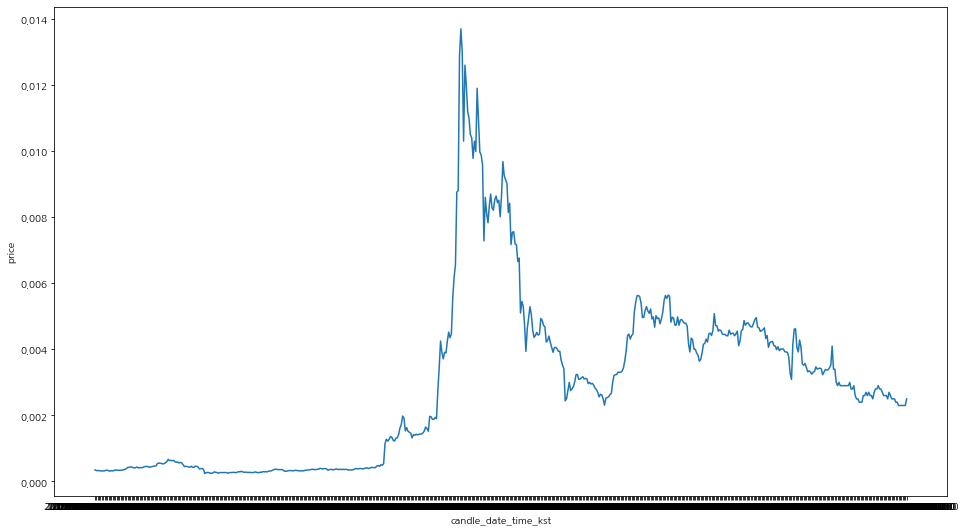

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=btt['trade_price'], x=btt.index)
plt.xlabel('candle_date_time_kst')
plt.ylabel('price')

In [13]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [14]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['change_rate', 'candle_acc_trade_volume', 'trade_price']
# scale_cols = ['trade_price']
# 스케일 후 columns
scaled = scaler.fit_transform(btt[scale_cols])

In [15]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [16]:
train_size = .8
n_train = int(np.floor(scaled.shape[0] * train_size))
train = scaled[: n_train]
test = scaled[n_train - WINDOW_SIZE:]

In [17]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, False)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=64, kernel_size= 6,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 3]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [55]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [56]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 20, 64)            1216      
                                                                 
 lstm_12 (LSTM)              (None, 16)                5184      
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


In [57]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'btt_with_volume_ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [58]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, ]) # earlystopping

Epoch 1/50
     11/Unknown - 2s 11ms/step - loss: 0.0238 - mse: 0.0477
Epoch 1: val_loss improved from inf to 0.00062, saving model to tmp/btt_with_volume_ckeckpointer.ckpt
15/15 [==============================] - 3s 61ms/step - loss: 0.0205 - mse: 0.0410 - val_loss: 6.1755e-04 - val_mse: 0.0012
Epoch 2/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0058 - mse: 0.0117
Epoch 2: val_loss did not improve from 0.00062
15/15 [==============================] - 0s 17ms/step - loss: 0.0050 - mse: 0.0101 - val_loss: 6.2106e-04 - val_mse: 0.0012
Epoch 3/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0019 - mse: 0.0039
Epoch 3: val_loss did not improve from 0.00062
15/15 [==============================] - 0s 16ms/step - loss: 0.0021 - mse: 0.0042 - val_loss: 7.3678e-04 - val_mse: 0.0015
Epoch 4/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0021 - mse: 0.0042       
Epoch 4: val_loss did not improve from 0.00062
15/15 [==============================] -

In [59]:
model.load_weights(filename)

In [60]:
pred = model.predict(test_data)

In [61]:
pred.shape

(120, 1)

## Plot result

In [62]:
np.expand_dims(train[-WINDOW_SIZE:, 2], axis = -1).shape

(20, 1)

In [63]:
pred[WINDOW_SIZE:, : ].shape

(100, 1)

In [64]:
pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis = 1)
pred_plot = np.concatenate((train, pred_plot))
pred_plot = scaler.inverse_transform(pred_plot)[:, 2]
# 원래 데이터를 그대로 사용
actual_plot = scaler.inverse_transform(np.concatenate((train, test[WINDOW_SIZE:, :])))[:, 2]

In [65]:
pred_plot.shape

(600,)

In [66]:
print(f'sMAPE = {smape(actual_plot[train.shape[0]:], pred_plot[train.shape[0]:])}')

sMAPE = 6.265873770878492


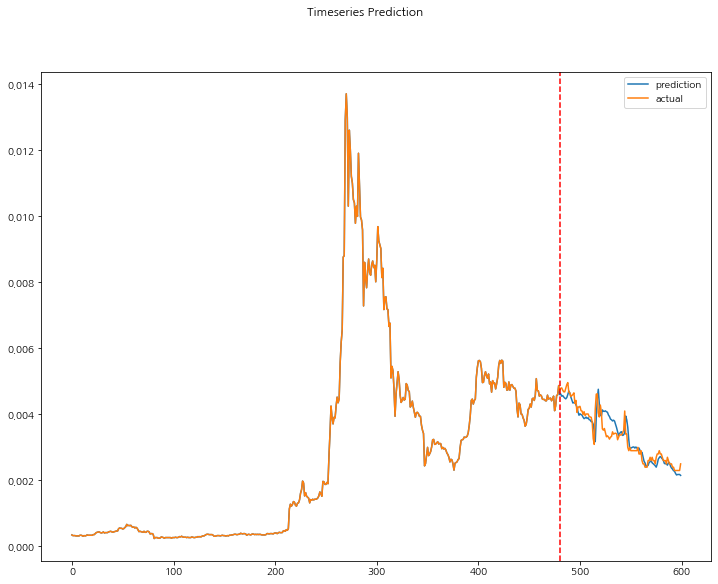

In [67]:
plt.figure(figsize=(12, 9))
plt.plot(pred_plot, label='prediction')
plt.plot(actual_plot, label='actual')
plt.axvline(x = train.shape[0], c = 'r', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

### OOT test

In [68]:
import pickle 

with open('../data/crypto_currency_oot.pickle', 'rb') as f:
    oot_data = pickle.load(f)

In [69]:
data['KRW-BTT'].tail()['trade_price']

4    0.0023
3    0.0023
2    0.0023
1    0.0023
0    0.0025
Name: trade_price, dtype: float64

In [70]:
oot_btt = oot_data['KRW-BTT']
oot_scaled = scaler. transform(oot_btt[scale_cols])
oot_scaled = np.concatenate((test[-WINDOW_SIZE:, :], oot_scaled))

In [71]:
oot_test_data = windowed_dataset(oot_scaled, WINDOW_SIZE, BATCH_SIZE, False)


In [72]:
oot_pred = model.predict(oot_test_data)

In [73]:
np.concatenate((np.expand_dims(test[-WINDOW_SIZE:, 2], axis = -1), oot_pred)).shape

(60, 1)

In [74]:
np.concatenate((oot_scaled[:,0:2], np.concatenate((np.expand_dims(test[-WINDOW_SIZE:, 2], axis = -1), oot_pred))), axis = 1).shape

(60, 3)

In [75]:
oot_actual_plot.shape

NameError: name 'oot_actual_plot' is not defined

In [76]:
# oot pred 데이터 만들기
oot_pred_plot = np.concatenate((oot_scaled[WINDOW_SIZE:,0:2], oot_pred), axis = 1)
# pred 데이터 만들기
pred_plot = np.concatenate((test[WINDOW_SIZE:,0:2], pred), axis = 1)
# 모두 합해서 역변환하기
oot_pred_plot = scaler.inverse_transform(np.concatenate((train, pred_plot, oot_pred_plot)))[:, 2]
# Actual 데이터 만들기
oot_actual_plot = scaler.inverse_transform(np.concatenate((train, test[WINDOW_SIZE:, :], oot_scaled[WINDOW_SIZE:, :])))[:, 2]

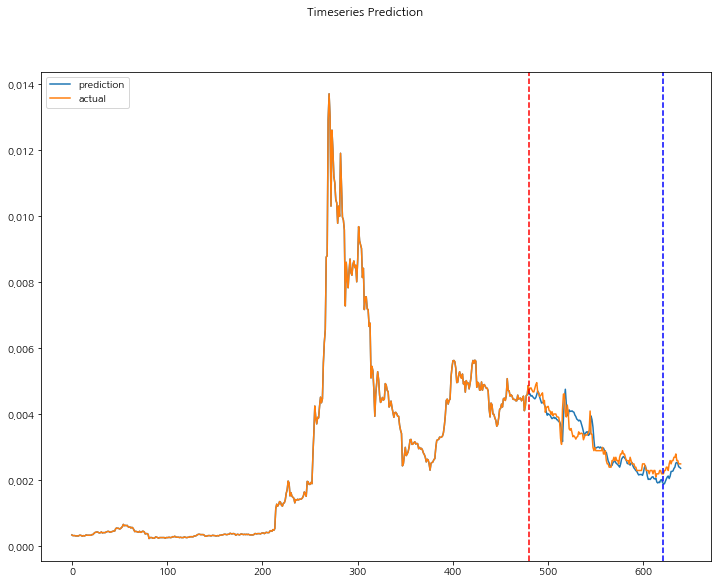

In [77]:
plt.figure(figsize=(12, 9))
plt.plot(oot_pred_plot, label='prediction')
plt.plot(oot_actual_plot, label='actual')
plt.axvline(x = train.shape[0], c = 'r', linestyle = '--')
plt.axvline(x = train.shape[0] + test.shape[0], c = 'b', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

In [284]:
print(f'sMAPE = {smape(oot_actual_plot[train.shape[0] + test.shape[0]:], oot_pred_plot[train.shape[0] + test.shape[0]:])}')

sMAPE = 5.164058643550302
